### **Importing Libraries**

In [1]:
import os
import pandas as pd
import torch 
from torch.utils.data import Dataset, DataLoader
from skimage import io
import torch.nn as nn
import torch.optim as optim
from torchvision import transforms
from tqdm import tqdm

### **DataLoader**

In [ ]:
class DocumentImageDataset(Dataset):
    def __init__(self, csv_file, root_dir , phase ,transform = None):
        self.annotations = pd.read_csv(csv_file)
        self.transform = transform
        self.root_dir = os.path.join(root_dir, phase)
    
    def __len__(self):
        return len(self.annotations)
    
    def __getitem__(self, index):
        img_path = os.path.join(self.root_dir, self.annotations.iloc[index, 0])
        image = io.imread(img_path)
        y_label = torch.tensor(int(self.annotations.iloc[index, 1]))

        if self.transform:
            image = self.transform(image)
        
        return (image, y_label)

### **Model** 

In [2]:
class Docmodel(nn.Module):
    def __init__(self, p) -> None:
        super(Docmodel, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=32, kernel_size=(3,3), stride=(1,1), padding=(0,0))
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=(3,3), stride=(1,1), padding=(0,0))
        self.conv3 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=(3,3), stride=(1,1), padding=(0,0))
        self.conv4 = nn.Conv2d(in_channels=128, out_channels=256, kernel_size=(3,3), stride=(1,1), padding=(0,0))
        self.conv5 = nn.Conv2d(in_channels=256, out_channels=512, kernel_size=(3,3), stride=(1,1), padding=(0,0))
        self.maxpool = nn.MaxPool2d(kernel_size=(2,2),stride=(2,2))
        self.conv1_bn = nn.BatchNorm2d(32)
        self.conv2_bn = nn.BatchNorm2d(64)
        self.conv3_bn = nn.BatchNorm2d(128)
        self.conv4_bn = nn.BatchNorm2d(256)
        self.conv5_bn = nn.BatchNorm2d(512)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout2d(p)
        self.linear1 = nn.Linear(51200,512)
        self.linear2 = nn.Linear(512,8)
        self.flatten = nn.Flatten()
        self.softmax = nn.Softmax(dim=1)
    
    def forward(self, x):

        # First cnn Layer
        x = self.conv1(x)
        #print("Conv: ",x.shape)
        x = self.relu(x)
        #print("Relu: ",x.shape)
        x = self.conv1_bn(x)
        #print("BatchNorm: ",x.shape)
        x = self.maxpool(x)
        #print("Maxpool: ",x.shape)
        x = self.dropout(x)
        #print("Dropout: ",x.shape)

        # second cnn Layer
        x = self.conv2(x)
        x = self.relu(x)
        x = self.conv2_bn(x)
        x = self.maxpool(x)
        x = self.dropout(x)

        # Third cnn Layer
        x = self.conv3(x)
        x = self.relu(x)
        x = self.conv3_bn(x)
        x = self.maxpool(x)
        x = self.dropout(x)

        # Fourth cnn Layer
        x = self.conv4(x)
        x = self.relu(x)
        x = self.conv4_bn(x)
        x = self.maxpool(x)
        x = self.dropout(x)

        # Fifth cnn Layer
        x = self.conv5(x)
        x = self.relu(x)
        x = self.conv5_bn(x)
        x = self.maxpool(x)
        x = self.dropout(x)

        # Flatten the layer
        x = self.flatten(x)

        # Dense Layers
        x = self.linear1(x)
        x = self.linear2(x)
        
        # softmax Layer 
        x = self.softmax(x)

        return x

### **Computing mean and std for train and validation set**

In [3]:
def get_mean_std(loader):
    # Compute mean and std for all the images in given set
    channels_sum, channels_squared_sum, num_batches = 0, 0, 0
    for data, _ in loader:
        channels_sum += torch.mean(data, dim=[0, 2, 3])
        channels_squared_sum += torch.mean(data**2, dim = [0, 2, 3])
        num_batches += 1
    
    mean = channels_sum / num_batches
    std = (channels_squared_sum / num_batches - mean**2)**0.5
    
    return mean, std

In [5]:

root_dir = "/kaggle/input/document-rotated-dataset/document_rotated_dataset"
batch_size = 64

train_csv_path = os.path.join(root_dir, "train_data_labels.csv")
valid_csv_path = os.path.join(root_dir, "valid_data_labels.csv")

# Loading the train and validation data
train_set = DocumentImageDataset(csv_file = train_csv_path, root_dir = root_dir, phase = "train", transform = transforms.ToTensor())
valid_set = DocumentImageDataset(csv_file = valid_csv_path, root_dir = root_dir, phase = "valid", transform = transforms.ToTensor())


train_dataloader = DataLoader(dataset=train_set, batch_size=batch_size)
mean, std = get_mean_std(train_dataloader)
print(mean, std)

validation_dataloader = DataLoader(dataset=valid_set, batch_size=batch_size)
mean, std = get_mean_std(validation_dataloader)
print(mean, std)


tensor([0.5620, 0.5665, 0.5679]) tensor([0.3959, 0.3972, 0.3995])
tensor([0.5612, 0.5638, 0.5645]) tensor([0.3961, 0.3972, 0.3998])


In [6]:
# Initializing the necessary transformation for preprocessing of train and validation set 

train_transform = transforms.Compose([
                    transforms.ToTensor(), 
                    transforms.Normalize(mean = [0.5620, 0.5665, 0.5679], std = [0.3959, 0.3972, 0.3995])
                    ])

valid_transform = transforms.Compose([
                    transforms.ToTensor(), 
                    transforms.Normalize(mean = [0.5612, 0.5638, 0.5645], std = [0.3961, 0.3972, 0.3998])
                ])


### **Model Training** 

In [7]:
# Set up device 
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Initializing the hyperparameters
learning_rate = 0.00001
batch_size = 64
num_epoch = 50
mini_valid_loss = float('Inf')

# Initializing the file paths
model_save_path = "/kaggle/working/saved_model_E20.pt"
root_dir = "/kaggle/input/document-rotated-dataset/document_rotated_dataset"

train_csv_path = os.path.join(root_dir, "train_data_labels.csv")
valid_csv_path = os.path.join(root_dir, "valid_data_labels.csv")

# Loading the train and validation data
train_set = DocumentImageDataset(csv_file = train_csv_path, root_dir = root_dir, phase = "train",transform = train_transform)
valid_set = DocumentImageDataset(csv_file = valid_csv_path, root_dir = root_dir, phase = "valid",transform = valid_transform)


train_dataloader = DataLoader(dataset=train_set, batch_size=batch_size, shuffle=True)
validation_dataloader = DataLoader(dataset=valid_set, batch_size=batch_size, shuffle=True)

print(f"Train size:{len(train_set)} valid size:{len(valid_set)}")

# Dropout with p = 0.25
p = 0.25
model = Docmodel(p)
model.to(device)
model.train()

# Loss and optimizer 
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr = learning_rate)

# Store the training and validation loss values for each epoch
epoch_train_loss = []
epoch_valid_loss = []

for epoch in range(0,num_epoch):

    train_loss = []
    train_num_correct = 0
    train_num_samples = 0

    train_loop = tqdm(enumerate(train_dataloader), total=len(train_dataloader), leave=False)

    for batch_idx, (data, labels) in train_loop:

        # Get data to cuda
        data = data.to(device)
        labels = labels.to(device)
        #print("data shape: ", data.size())

        # Forward pass
        output = model(data)
        _, pred_labels = torch.max(output, 1)

        # Calculating the loss
        loss = criterion(output, labels)
        train_loss.append(loss.item())
        
        # Calculating the accuracy
        batch_correct = torch.sum(pred_labels == labels) 
        train_num_correct += batch_correct
        train_num_samples += pred_labels.size(0)

        # Backward
        optimizer.zero_grad()
        loss.backward()

        # Gradient descent 
        optimizer.step()

        # update progress bar
        train_loop.set_description(f"Epoch [{epoch}/{num_epoch}]")
        train_loop.set_postfix(loss = loss.item(), acc = (batch_correct/data.size(0)).item())        

    
    # Evaluating the model using validation set
    
    valid_loss = []
    valid_num_correct = 0
    valid_num_samples = 0
    model.eval()
    
    valid_loop = tqdm(enumerate(validation_dataloader), total=len(validation_dataloader), leave=False)

    for batch_idx, (data, labels) in valid_loop:
        
        # Get data to cuda
        data = data.to(device)
        labels = labels.to(device)

        # Forward pass
        output = model(data)
        _, pred_labels = torch.max(output, 1)

        # Calculating the loss
        loss = criterion(output, labels)
        valid_loss.append(loss.item())
        
        # Calculating the accuracy
        batch_correct = torch.sum(pred_labels == labels) 
        valid_num_correct += batch_correct
        valid_num_samples += pred_labels.size(0)

        if mini_valid_loss > sum(valid_loss)/len(valid_loss):
            mini_valid_loss = sum(valid_loss)/len(valid_loss)
            torch.save(model.state_dict(), model_save_path)
        
        # update progress bar    
        valid_loop.set_description(f"Epoch [{epoch}/{num_epoch}]")
        valid_loop.set_postfix(loss = loss.item(), acc = (batch_correct/data.size(0)).item())        

    print(f"Epoch: {epoch} Training Loss: {sum(train_loss)/len(train_loss)}, Train Accuracy:{float(train_num_correct)/float(train_num_samples)}, Validation Loss: {sum(valid_loss)/len(valid_loss)}, Validation Accuracy:{float(valid_num_correct)/float(valid_num_samples)}")
    epoch_train_loss.append(sum(train_loss)/len(train_loss))
    epoch_valid_loss.append(sum(valid_loss)/len(valid_loss))

Train size:6583 valid size:732


Epoch: 0 Training Loss: 1.9194462773869339, Train Accuracy:0.35090384323256874, Validation Loss: 1.8300341268380482, Validation Accuracy:0.4808743169398907


Epoch: 1 Training Loss: 1.7093347357314768, Train Accuracy:0.61279052103904, Validation Loss: 1.6421849926312764, Validation Accuracy:0.657103825136612


Epoch: 2 Training Loss: 1.5785588998239017, Train Accuracy:0.7282394045268115, Validation Loss: 1.5814292629559834, Validation Accuracy:0.7131147540983607


Epoch: 3 Training Loss: 1.5209742541452056, Train Accuracy:0.7788242442655324, Validation Loss: 1.541566640138626, Validation Accuracy:0.7595628415300546


Epoch: 4 Training Loss: 1.4858033888548323, Train Accuracy:0.812547470758013, Validation Loss: 1.5265011489391327, Validation Accuracy:0.76775956284153


Epoch: 5 Training Loss: 1.4642621116730774, Train Accuracy:0.8303205225581042, Validation Loss: 1.514887015024821, Validation Accuracy:0.7663934426229508


Epoch: 6 Training Loss: 1.4492768292288178, Train Accuracy:0.8408020659273887, Validation Loss: 1.5026069382826488, Validation Accuracy:0.7827868852459017


Epoch: 7 Training Loss: 1.4374145442999682, Train Accuracy:0.8505240771684642, Validation Loss: 1.4911228716373444, Validation Accuracy:0.7950819672131147


Epoch: 8 Training Loss: 1.4260999080046868, Train Accuracy:0.8582713048761963, Validation Loss: 1.4684004286924999, Validation Accuracy:0.8114754098360656


Epoch: 9 Training Loss: 1.3584423967935506, Train Accuracy:0.9279963542457846, Validation Loss: 1.4139756957689922, Validation Accuracy:0.8647540983606558


Epoch: 10 Training Loss: 1.3303648013513065, Train Accuracy:0.9539723530305332, Validation Loss: 1.3941566050052643, Validation Accuracy:0.889344262295082


Epoch: 11 Training Loss: 1.3184453839237251, Train Accuracy:0.9639981771228923, Validation Loss: 1.3829023937384288, Validation Accuracy:0.9002732240437158


Epoch: 12 Training Loss: 1.3102740720637793, Train Accuracy:0.9711377791280571, Validation Loss: 1.3941546777884166, Validation Accuracy:0.889344262295082


Epoch: 13 Training Loss: 1.3023127953983047, Train Accuracy:0.9784292875588637, Validation Loss: 1.3732254803180695, Validation Accuracy:0.9084699453551912


Epoch: 14 Training Loss: 1.297778854092348, Train Accuracy:0.9823788546255506, Validation Loss: 1.365248699982961, Validation Accuracy:0.9112021857923497


Epoch: 15 Training Loss: 1.2939761379390087, Train Accuracy:0.9849612638614613, Validation Loss: 1.3696163197358449, Validation Accuracy:0.9166666666666666


Epoch: 16 Training Loss: 1.2909020301207756, Train Accuracy:0.9866322345435212, Validation Loss: 1.3666518032550812, Validation Accuracy:0.912568306010929


Epoch: 17 Training Loss: 1.289887519716059, Train Accuracy:0.9878474859486557, Validation Loss: 1.3700179159641266, Validation Accuracy:0.9139344262295082


Epoch: 18 Training Loss: 1.2881413779212434, Train Accuracy:0.9889108309281482, Validation Loss: 1.3644722998142242, Validation Accuracy:0.9084699453551912


Epoch: 19 Training Loss: 1.2857580451132025, Train Accuracy:0.9904298951845663, Validation Loss: 1.3617628117402394, Validation Accuracy:0.9153005464480874


Epoch: 20 Training Loss: 1.2848829771708516, Train Accuracy:0.9908856144614917, Validation Loss: 1.3597386280695598, Validation Accuracy:0.9153005464480874


Epoch: 21 Training Loss: 1.2839126285997409, Train Accuracy:0.9914932401640589, Validation Loss: 1.3616758584976196, Validation Accuracy:0.9153005464480874


Epoch: 22 Training Loss: 1.283218255320799, Train Accuracy:0.9919489594409844, Validation Loss: 1.3617237210273743, Validation Accuracy:0.9180327868852459


Epoch: 23 Training Loss: 1.282687471908273, Train Accuracy:0.9924046787179097, Validation Loss: 1.352988064289093, Validation Accuracy:0.9234972677595629


Epoch: 24 Training Loss: 1.2824031438642336, Train Accuracy:0.9927084915691934, Validation Loss: 1.3583113253116608, Validation Accuracy:0.9180327868852459


Epoch: 25 Training Loss: 1.2815093774239994, Train Accuracy:0.9933161172717606, Validation Loss: 1.3616130848725636, Validation Accuracy:0.9180327868852459


Epoch: 26 Training Loss: 1.281178459380437, Train Accuracy:0.9939237429743278, Validation Loss: 1.3562334775924683, Validation Accuracy:0.9193989071038251


Epoch: 27 Training Loss: 1.2808048354769217, Train Accuracy:0.9939237429743278, Validation Loss: 1.3545244733492534, Validation Accuracy:0.9180327868852459


Epoch: 28 Training Loss: 1.2816443559035515, Train Accuracy:0.9934680236974024, Validation Loss: 1.3609243134657543, Validation Accuracy:0.9193989071038251


Epoch: 29 Training Loss: 1.2832644194075205, Train Accuracy:0.9924046787179097, Validation Loss: 1.3515389263629913, Validation Accuracy:0.930327868852459


Epoch: 30 Training Loss: 1.2800764343113575, Train Accuracy:0.9945313686768951, Validation Loss: 1.3554914891719818, Validation Accuracy:0.9262295081967213


Epoch: 31 Training Loss: 1.27977666461352, Train Accuracy:0.9946832751025368, Validation Loss: 1.3484597702821095, Validation Accuracy:0.9289617486338798


Epoch: 32 Training Loss: 1.2796533755885744, Train Accuracy:0.9946832751025368, Validation Loss: 1.3537504772345226, Validation Accuracy:0.9289617486338798


Epoch: 33 Training Loss: 1.2794856562197787, Train Accuracy:0.9948351815281786, Validation Loss: 1.3505680759747822, Validation Accuracy:0.924863387978142


Epoch: 34 Training Loss: 1.279293476956562, Train Accuracy:0.9949870879538204, Validation Loss: 1.3505182266235352, Validation Accuracy:0.9234972677595629


Epoch: 35 Training Loss: 1.27918687491741, Train Accuracy:0.9951389943794623, Validation Loss: 1.3553414046764374, Validation Accuracy:0.9289617486338798


Epoch: 36 Training Loss: 1.2789550128492337, Train Accuracy:0.9952909008051041, Validation Loss: 1.3546911180019379, Validation Accuracy:0.9221311475409836


Epoch: 37 Training Loss: 1.2789416324745104, Train Accuracy:0.9952909008051041, Validation Loss: 1.3506507178147633, Validation Accuracy:0.9234972677595629


Epoch: 38 Training Loss: 1.2789056486296422, Train Accuracy:0.9952909008051041, Validation Loss: 1.3502044181029003, Validation Accuracy:0.9207650273224044


Epoch: 39 Training Loss: 1.2787301274179255, Train Accuracy:0.9954428072307459, Validation Loss: 1.3529624144236247, Validation Accuracy:0.9221311475409836


Epoch: 40 Training Loss: 1.2787132020135528, Train Accuracy:0.9954428072307459, Validation Loss: 1.3491877814133961, Validation Accuracy:0.9207650273224044


Epoch: 41 Training Loss: 1.2788356739340476, Train Accuracy:0.9954428072307459, Validation Loss: 1.3552523752053578, Validation Accuracy:0.9207650273224044


Epoch: 42 Training Loss: 1.278580241990321, Train Accuracy:0.9955947136563876, Validation Loss: 1.3464837869008381, Validation Accuracy:0.9262295081967213


Epoch: 43 Training Loss: 1.286972493801302, Train Accuracy:0.9873917666717302, Validation Loss: 1.3584707876046498, Validation Accuracy:0.9180327868852459


Epoch: 44 Training Loss: 1.2997753076182985, Train Accuracy:0.9779735682819384, Validation Loss: 1.368780255317688, Validation Accuracy:0.9084699453551912


Epoch: 45 Training Loss: 1.2907736093095206, Train Accuracy:0.9864803281178793, Validation Loss: 1.3577272295951843, Validation Accuracy:0.9221311475409836


Epoch: 46 Training Loss: 1.2822870895700547, Train Accuracy:0.9940756493999696, Validation Loss: 1.3473916252454121, Validation Accuracy:0.9289617486338798


Epoch: 47 Training Loss: 1.278747401191193, Train Accuracy:0.9957466200820295, Validation Loss: 1.3471016089121501, Validation Accuracy:0.924863387978142


Epoch: 48 Training Loss: 1.2782240805116671, Train Accuracy:0.9960504329333131, Validation Loss: 1.3443325559298198, Validation Accuracy:0.930327868852459


Epoch: 49 Training Loss: 1.2781446408299566, Train Accuracy:0.9960504329333131, Validation Loss: 1.3473140895366669, Validation Accuracy:0.930327868852459


Epoch: 50 Training Loss: 1.2778426165719634, Train Accuracy:0.9963542457845966, Validation Loss: 1.343592604001363, Validation Accuracy:0.9316939890710383


### **Plotting the training and validation loss** 

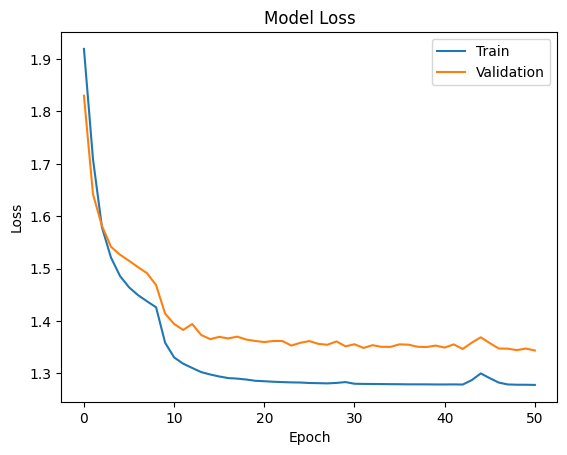

In [9]:
import matplotlib.pyplot as plt

plt.plot(epoch_train_loss)
plt.plot(epoch_valid_loss)
plt.title("Model Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend(['Train', 'Validation'])
plt.show()

### **Computing mean and std for test set** 

In [10]:
test_csv_path = os.path.join(root_dir, "test_data_labels.csv")

test_set = DocumentImageDataset(csv_file = test_csv_path, root_dir = root_dir, phase = "test", transform = transforms.ToTensor())

test_dataloader = DataLoader(dataset=test_set, batch_size=batch_size)
mean, std = get_mean_std(test_dataloader)
print(mean, std)


tensor([0.5612, 0.5638, 0.5645]) tensor([0.3961, 0.3972, 0.3998])


### **Model Evaluation on test set** 

In [11]:
#root_dir = "/kaggle/input/test-dataset"

test_transform = transforms.Compose([
                    transforms.ToTensor(), 
                    transforms.Normalize(mean = [0.5612, 0.5638, 0.5645], std = [0.3961, 0.3972, 0.3998])
                    ])

test_csv_file = os.path.join(root_dir, "test_data_labels.csv")
test_set = DocumentImageDataset(csv_file = test_csv_file, root_dir = root_dir, phase = "test",transform = test_transform)
test_dataloader = DataLoader(dataset=test_set, batch_size=64, shuffle=True)


model = Docmodel(p)
model.load_state_dict(torch.load(model_save_path))
model.to(device)
test_loss = []
test_num_correct = 0
test_num_samples = 0
model.eval()

output_labels = []
original_labels = []

test_loop = tqdm(enumerate(test_dataloader), total=len(test_dataloader), leave=False)

for batch_idx, (data, labels) in test_loop:

    # Get data to cuda
    data = data.to(device)
    labels = labels.to(device)

    # Forward pass
    output = model(data)
    _, pred_labels = torch.max(output, 1)
    
    # Calculating the loss
    loss = criterion(output, labels)
    test_loss.append(loss.item())

    # Calculating the accuracy
    batch_correct = torch.sum(pred_labels == labels) 
    
    output_labels.extend(pred_labels.tolist())
    original_labels.extend(labels.tolist())
    
    test_num_correct += batch_correct
    test_num_samples += pred_labels.size(0)

print(f"Test Loss: {sum(test_loss)/len(test_loss)}, Test Accuracy:{float(test_num_correct)/float(test_num_samples)}")

Test Loss: 1.3566733400026958, Test Accuracy:0.9180327868852459


### **Evaluating test results** 

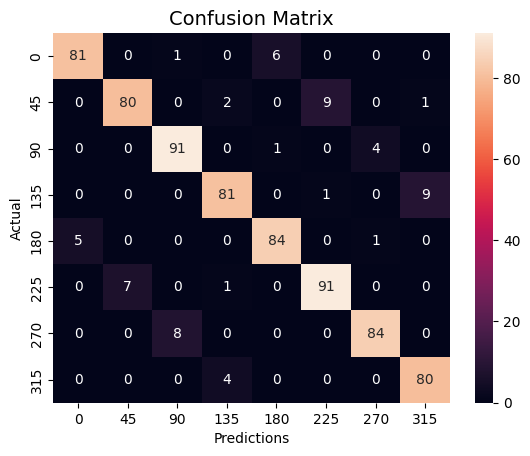

In [13]:
import numpy as np
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

cm = confusion_matrix(original_labels, output_labels)
target_names = ['0', '45', '90', '135', '180', '225', '270', '315']
sns.heatmap(cm,
           annot = True,
           fmt = 'g',
           xticklabels = target_names,
            yticklabels = target_names)

plt.xlabel('Predictions', fontsize =  10)
plt.ylabel('Actual', fontsize =  10)
plt.title('Confusion Matrix', fontsize = 14)
plt.show()


In [14]:
from sklearn.metrics import classification_report
target_names = ['0', '45', '90', '135', '180', '225', '270', '315']
print(classification_report(original_labels, output_labels, target_names = target_names))

              precision    recall  f1-score   support

           0       0.94      0.92      0.93        88
          45       0.92      0.87      0.89        92
          90       0.91      0.95      0.93        96
         135       0.92      0.89      0.91        91
         180       0.92      0.93      0.93        90
         225       0.90      0.92      0.91        99
         270       0.94      0.91      0.93        92
         315       0.89      0.95      0.92        84

    accuracy                           0.92       732
   macro avg       0.92      0.92      0.92       732
weighted avg       0.92      0.92      0.92       732

